# Model

For denoising we have developed a model structure, which is shown below. We have used convolutional neural network model called autoencoder for our project. We have used this type because we needed at output the picture with same size as the one at input. 

At the beginning, we started to train our model with simple autoencoder, which was composed from one covolution layer, one maxpooling layer and one upsampling layer. After study process, we have applied methods of layer order from online articles. From this process we concluded that each convolution layer should be followed by a batch normalization layer, which normalize the activation from previous layer. We have added concatenate layer which groups main output from layer order with some individual layers for better detail at the end of layer assembly. In our project this skip connections had improved quality of output photos significantly. 

**Convolution layers**: We have used two types of convolutional layers: with 2x2 kernel size and with 3x3 kernel size. In earlier layers, we used 3x3 kernel sizes only, for the purpose of bigger noise presence at the begining of model layers.

**MaxPooling**: We have used 2x2 pool size max pooling layer to down-sample input image and reduce its dimensionality.

**UpSampling**: 2x2 size layer that will double the dimensions of input, to get a required output dimensionality after using MaxPooling layers

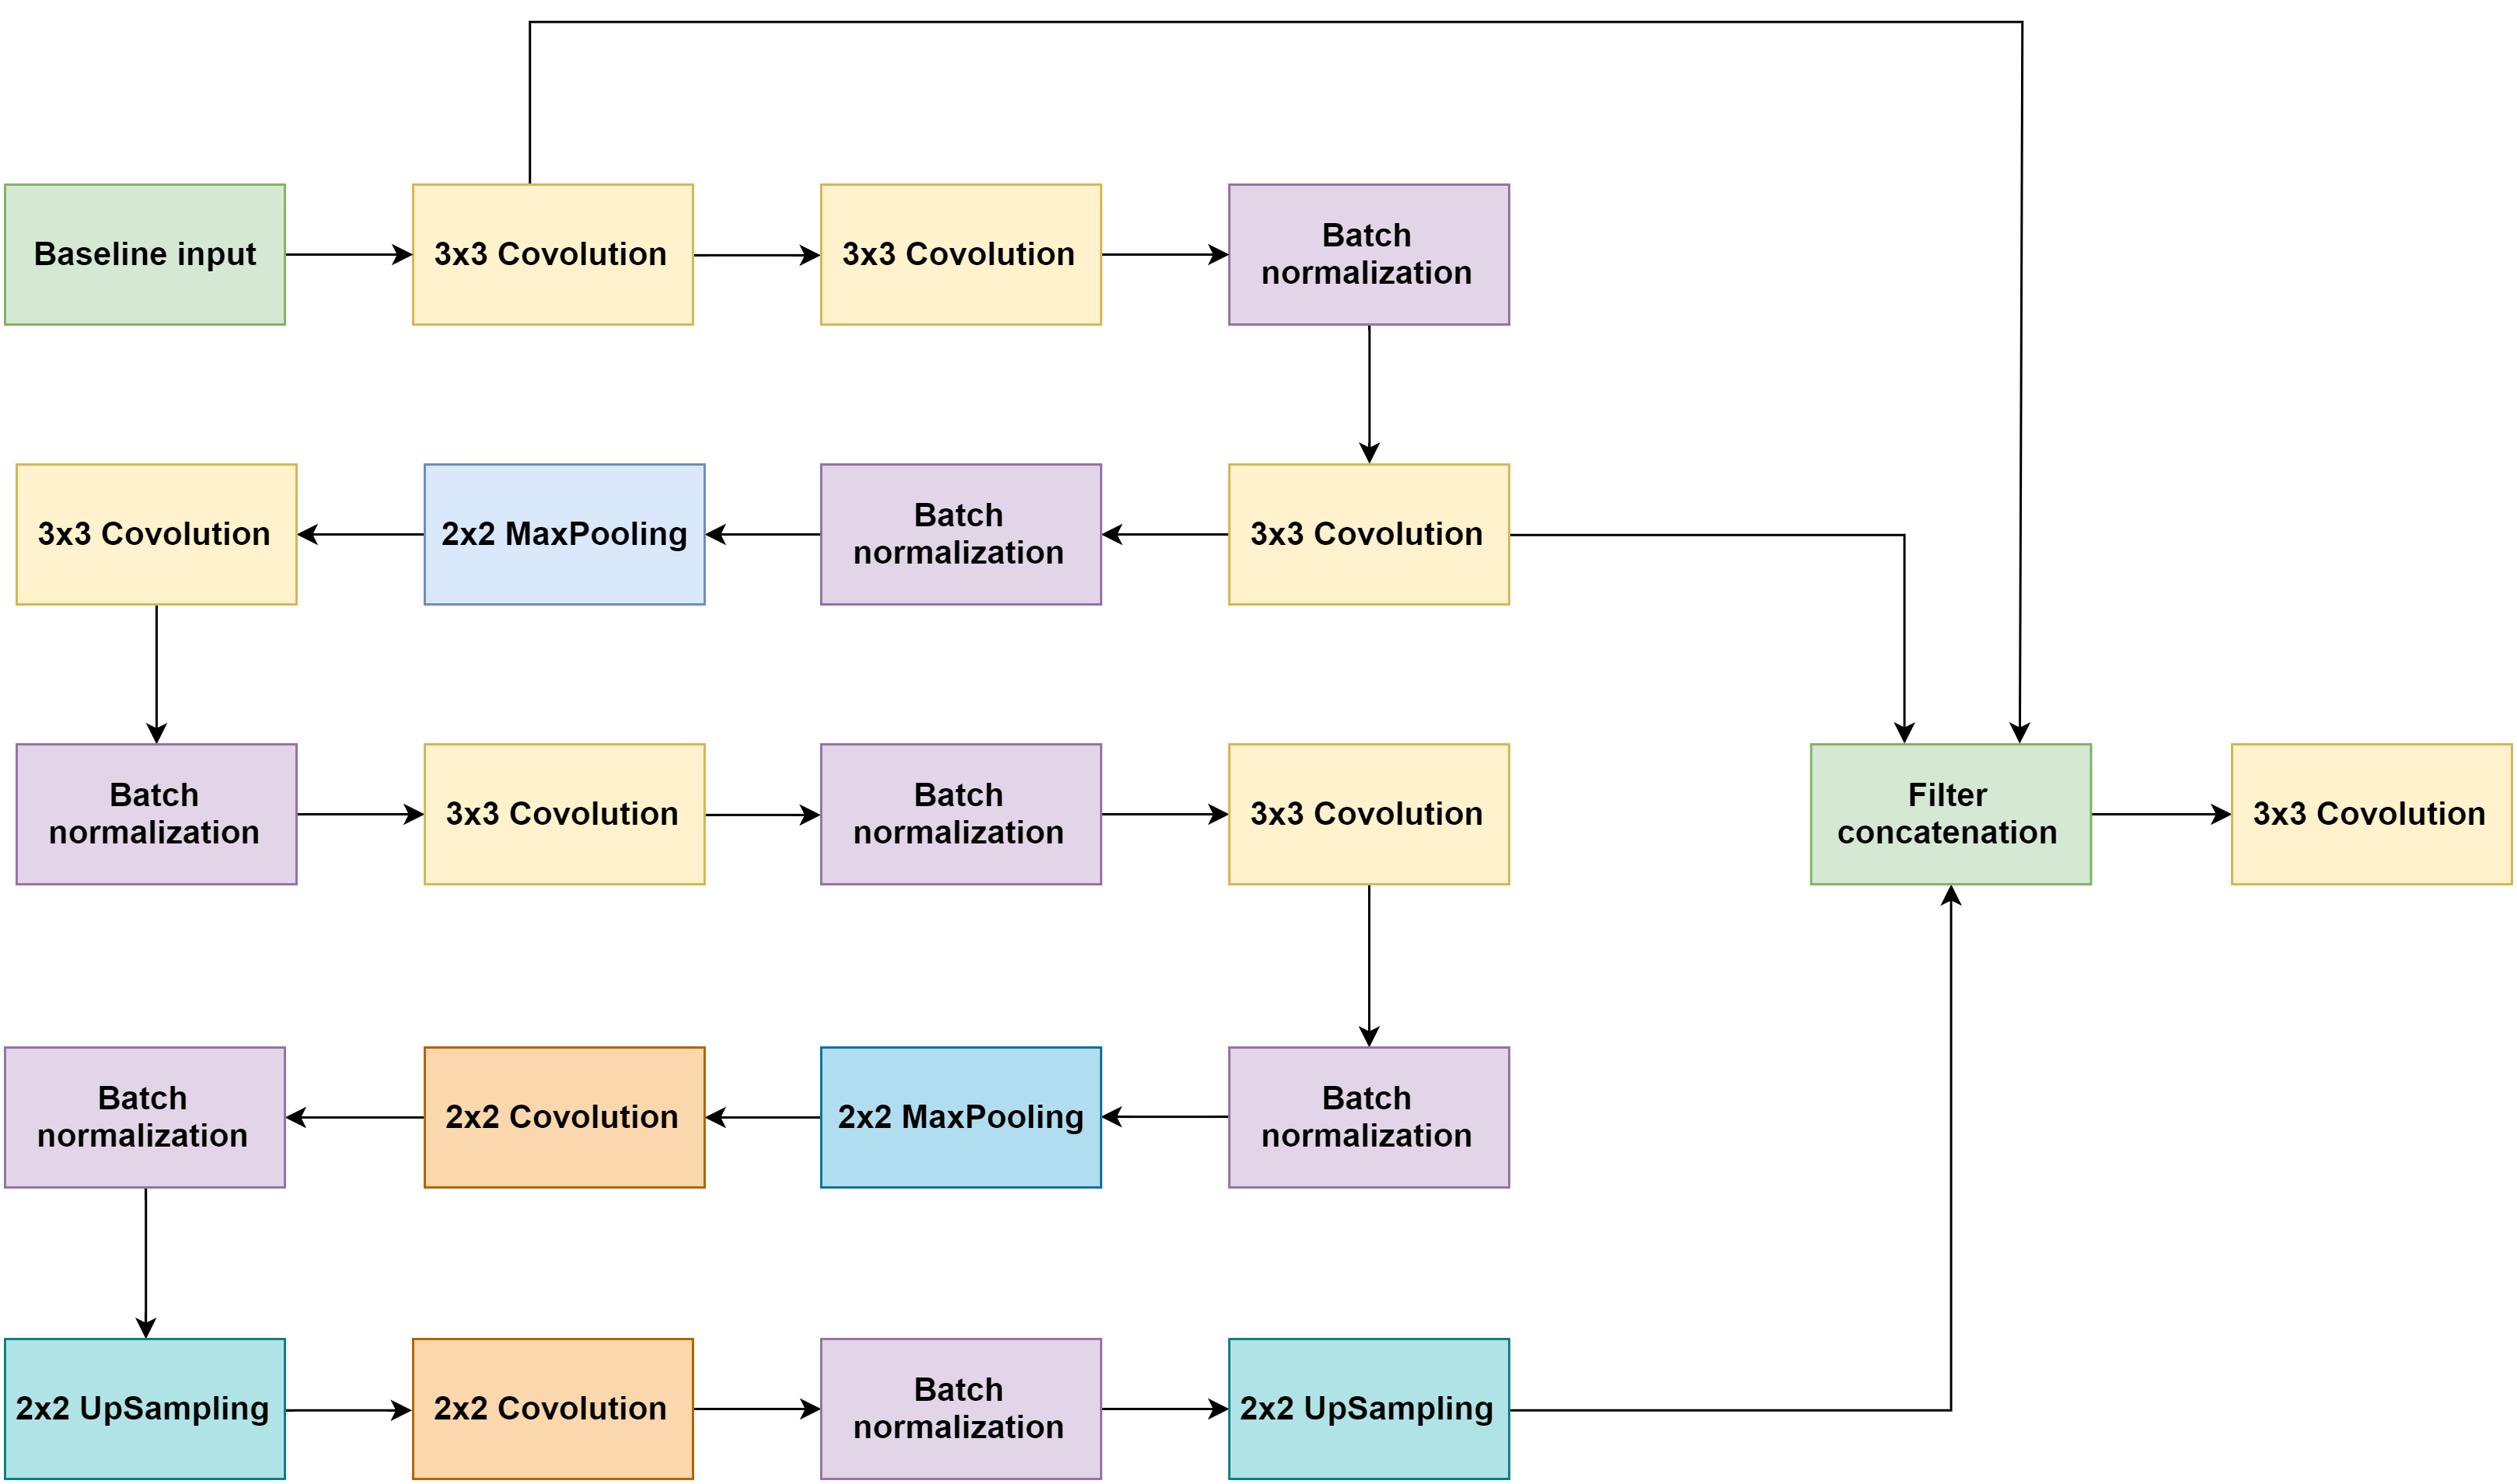

# Result of grayscale images denoising 

log directory: logs/2019-11-17-20-16

**FIRST ROW IS DENOISED**  
**SECOND ROW IS NOISED**  
**THIRD ROW IS ORIGINAL**

<img src="Pictures/1000_pictures.PNG">

# Result of rgb images denoising 

log directory: logs/2019-11-17-21-44

**FIRST ROW IS DENOISED**  
**SECOND ROW IS NOISED**  
**THIRD ROW IS ORIGINAL**

<img src="Pictures/rgb_denoise.PNG">


# Implementation

In [1]:
import tensorflow.keras as keras
import tensorflow.keras.layers as KL
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import Model, Sequential
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras as keras

%load_ext autoreload
%autoreload 2

%matplotlib notebook

%load_ext tensorboard
%tensorboard --logdir logs --bind_all

sys.path.append('..')

### Current implementation is set to rgb denoising, by changing constant `rgb_or_grayscale` to `1` will change it to grayscale denoising

In [6]:
IMG_SIZE = 128
num_of_pictures = 800
rgb_or_grayscale = 3 # 1 for grayscale, 3 for rgb

#### We load rgb pictures and by constant rgb_or_grayscale we determine if the model will be trained on rgb or grayscale images

In [7]:
import os
from os import listdir
from os.path import isfile, join
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image

mypath_orig = "./noise_generation/resized_orig"
mypath_noised = "./noise_generation/resized_noised"

onlyfiles_orig = [f for f in listdir(mypath_orig) if isfile(join(mypath_orig, f))]
onlyfiles_noised = [f for f in listdir(mypath_noised) if isfile(join(mypath_noised, f))]

original_images = np.empty([num_of_pictures,IMG_SIZE,IMG_SIZE,rgb_or_grayscale])
noised_images = np.empty([num_of_pictures,IMG_SIZE,IMG_SIZE,rgb_or_grayscale])

iterationOrig = 0
iterationNoised = 0

for q in onlyfiles_orig[:num_of_pictures]:
    name = mypath_orig +"/"+q
    original_images[iterationOrig] = image.img_to_array(image.load_img(name, target_size=(IMG_SIZE, IMG_SIZE)))
    original_images[iterationOrig] /= 255.0
    
    path = mypath_noised +"/"+ q.split('_')[0] + "_resized.jpg"
    noised_images[iterationOrig] = image.img_to_array(image.load_img(path, target_size=(IMG_SIZE, IMG_SIZE)))
    noised_images[iterationOrig] /= 255.0
    iterationOrig += 1

print(noised_images[299])
print(original_images.shape)
split = int(num_of_pictures*0.7)

train_orig = original_images[:split]
test_orig = original_images[split:]

train_noised = noised_images[:split]
test_noised = noised_images[split:]

[[[0.96078431 0.96078431 0.96078431]
  [0.95294118 0.95294118 0.95294118]
  [0.95294118 0.95294118 0.95294118]
  ...
  [0.42352941 0.45882353 0.25098039]
  [0.43921569 0.4745098  0.25098039]
  [0.42745098 0.46666667 0.23137255]]

 [[0.95686275 0.95686275 0.95686275]
  [0.95294118 0.95294118 0.95294118]
  [0.95686275 0.95686275 0.95686275]
  ...
  [0.43529412 0.47058824 0.25490196]
  [0.43529412 0.4745098  0.23921569]
  [0.43137255 0.47058824 0.23137255]]

 [[0.95686275 0.95686275 0.95686275]
  [0.95686275 0.95686275 0.95686275]
  [0.96078431 0.96078431 0.96078431]
  ...
  [0.42745098 0.4627451  0.24705882]
  [0.42745098 0.46666667 0.23137255]
  [0.43137255 0.47058824 0.23137255]]

 ...

 [[0.16470588 0.14509804 0.07058824]
  [0.15686275 0.13333333 0.07058824]
  [0.14901961 0.1372549  0.07058824]
  ...
  [0.44313725 0.43529412 0.23529412]
  [0.44705882 0.43921569 0.23921569]
  [0.44705882 0.43921569 0.24705882]]

 [[0.16078431 0.1372549  0.0745098 ]
  [0.16470588 0.14117647 0.07843137]


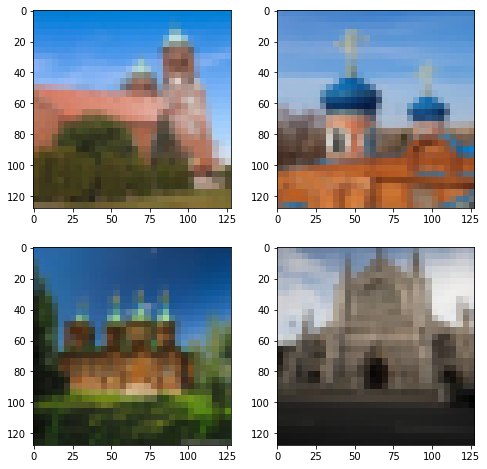

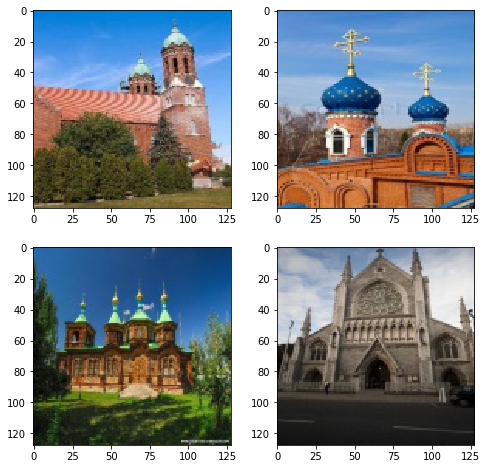

In [8]:
imgs = train_noised[:4]
_, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()
plt.gray()
for img, ax in zip(imgs, axs):
    ax.imshow(img[:,:,:])
plt.show()  

imgs = train_orig[:4]
_, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img[:,:,:])
plt.show()

#### Architecture is the same as in the description at the top of file

In [11]:
from datetime import datetime

input_img = Input(shape=(IMG_SIZE, IMG_SIZE, rgb_or_grayscale))

d1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(d1)
x = BatchNormalization()(x)
d2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(d2)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (2, 2), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = concatenate([x,d1,d2])


decoded = Conv2D(rgb_or_grayscale, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=keras.optimizers.Adam(lr=0.003), loss='mse')

dt =  datetime.now()
current_timestamp = str(dt.year) + '-' + str(dt.month) + '-' + str(dt.day) + '-' + str(dt.hour) + '-' + str(dt.minute)

callbacks = [
    keras.callbacks.TensorBoard(
        log_dir=os.path.join("logs", current_timestamp),
        histogram_freq=1,
        profile_batch=0)
]

# early_stopping = EarlyStopping(patience=5, verbose=1, monitor="loss")
# model_checkpoint = ModelCheckpoint('./encoder_rgb.hdf5', monitor="loss", save_best_only=True, verbose=1)
# reduce_lr = ReduceLROnPlateau(factor=0.1, patience=7, min_lr=0.00001, verbose = 1, monitor = "loss")

autoencoder.fit(train_noised, train_orig,
                epochs=30,
                batch_size=20,
                shuffle=True,
                validation_data=(test_noised, test_orig)
                )

Train on 560 samples, validate on 240 samples
Epoch 1/30
560/560 [==============================] - 10s 18ms/sample - loss: 0.0185 - val_loss: 0.0854
Epoch 2/30
560/560 [==============================] - 7s 13ms/sample - loss: 0.0101 - val_loss: 0.0529
Epoch 3/30
560/560 [==============================] - 7s 13ms/sample - loss: 0.0080 - val_loss: 0.0452
Epoch 4/30
560/560 [==============================] - 7s 13ms/sample - loss: 0.0079 - val_loss: 0.0341
Epoch 5/30
560/560 [==============================] - 7s 13ms/sample - loss: 0.0081 - val_loss: 0.0295
Epoch 6/30
560/560 [==============================] - 7s 13ms/sample - loss: 0.0074 - val_loss: 0.0250
Epoch 7/30
560/560 [==============================] - 7s 13ms/sample - loss: 0.0071 - val_loss: 0.0207
Epoch 8/30
560/560 [==============================] - 7s 13ms/sample - loss: 0.0067 - val_loss: 0.0172
Epoch 9/30
560/560 [==============================] - 7s 13ms/sample - loss: 0.0066 - val_loss: 0.0144
Epoch 10/30
560/560 [=====

#### We show the result of the model in comparision with noised version and the original image. 

27


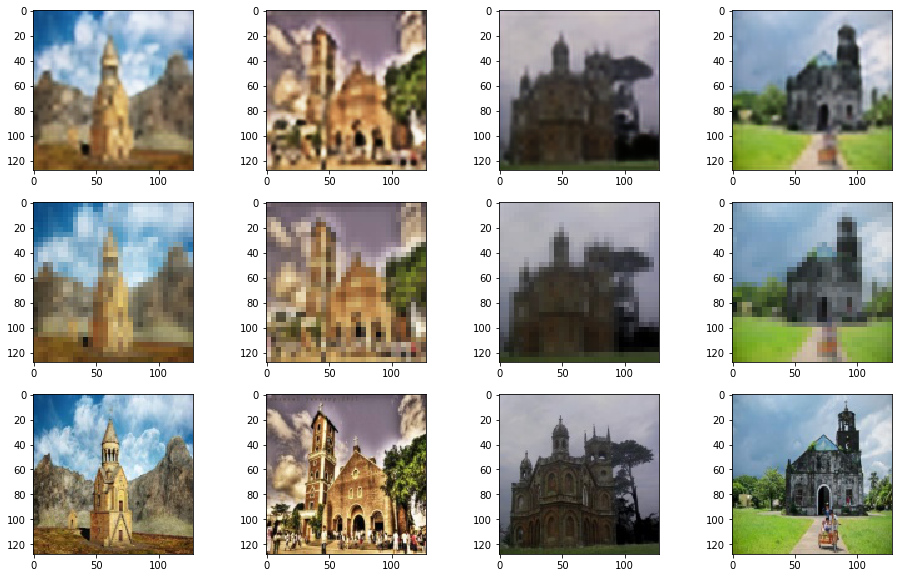

In [12]:
# FIRST ROW IS DENOISED
# SECOND ROW IS DEFAULT NOISED
# THIRD ROW IS ORIGINAL


count = 4
start = np.random.randint(0, num_of_pictures*0.3 - count)

print(start)
imgs = test_noised[start:start+count]
imgs = np.concatenate((imgs, test_noised[start:start+count], test_orig[start:start+count]))
_, axs = plt.subplots(3, count, figsize=(16, 10))

axs = axs.flatten()
i = 0
for img, ax in zip(imgs, axs):
    if (i < count):
        p_img = autoencoder.predict(img[np.newaxis,:,:,:])[0,:,:,:]
        ax.imshow(p_img[:,:,:])
    else:
        ax.imshow(img[:,:,:])
    i+=1
plt.show()   
